<a href="https://colab.research.google.com/github/growhelper/Project_Section1_/blob/main/n223a_evaluation_metrics_for_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

In [10]:
# Google Colab에서 하시는 경우 해당 셀을 먼저 실행
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install plotly==4.*

     |████████████████████████████████| 80 kB 3.7 MB/s 
     |████████████████████████████████| 245 kB 5.1 MB/s 
     |████████████████████████████████| 102 kB 64.3 MB/s 
     |████████████████████████████████| 62 kB 688 kB/s 
     |████████████████████████████████| 675 kB 49.1 MB/s 
     |████████████████████████████████| 3.1 MB 28.4 MB/s 
     |████████████████████████████████| 812 kB 71.6 MB/s 
     |████████████████████████████████| 28.5 MB 46 kB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=055a9e340105c15caacb7322e63acea1443c81ced7cc75c6bbe347c344b08bc1
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295207 sha256=42bf9e92473642897566b5baf0a2ecf78af8c1eb317bb7d0fa5d8e630248a32e
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully b

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#train_labels 에는 두 타겟이 있는데 지금은 vacc_h1n1_f만 사용

target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [3]:
# train, validation 데이터 셋 나눔
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [4]:
profile = ProfileReport(train, minimal=True).to_notebook_iframe() #Warning의 대부분이 결측치에 대한 것으로 후에 Imputer를 사용하여 처리하기

Summarize dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import numpy as np

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    df = df[selected_features]
    
    ## 합칠 것이 있나
    df['must'] = np.where((df['behavioral_face_mask']==1) &(df['behavioral_wash_hands']==1) , 1,0 )


    ## 사용하지 않을 특성을 삭제합니다.
    #X = X.drop(['id', 'date', 'waterfront'],axis=1)

    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

In [6]:
features = train.drop(columns=[target]).columns #타겟 제외한 컬럼 소환

In [7]:
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.
- **다음 조건에서 F beta score를 구하고 과제 제출폼에 제출하세요.**
    - TP = 4442, TN = 6165, FP = 1515, FN = 1930, 재현율에 정밀도의 2배 가중치를 부여합니다.

In [8]:
### ((1+BETA**2)*Precision*Recall)/((beta**2)**Precision+Recall)
Precision = 4442/(4442+1515)
Recall = 4442 / (4442+1930)
BETA=2 #정밀도에 주어지는 가중치를 베타라고 함. 여기선 2배 가중치

ANSWER = ((1+BETA**2)*Precision*Recall)/((BETA**2)**Precision+Recall)
ANSWER

0.7407724446383348

### 2) 모델을 학습한 후 Confusion matrix를 그리고 해석하세요
- 임계값을 조정한 후 confusion matrix를 그려보세요
- **(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화 양상을 과제 제출폼에 제출하세요.**
    1. 증가
    2. 감소
    3. 변화가 없다


In [9]:
from sklearn.pipeline import make_pipeline

# 파이프라인을 만들어 학습
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

검증 정확도:  0.8242201399596726


In [10]:
#sklearn.metrics.classification_report 를 사용하면 정밀도, 재현율을 확인
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      6416
           1       0.71      0.45      0.55      2015

    accuracy                           0.82      8431
   macro avg       0.78      0.70      0.72      8431
weighted avg       0.81      0.82      0.81      8431



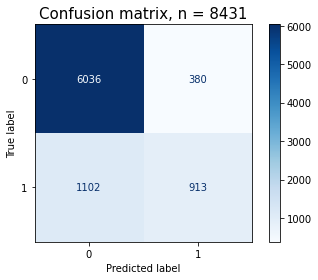

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [15]:
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.08, 0.11, 0.48, ..., 0.19, 0.02, 0.48])

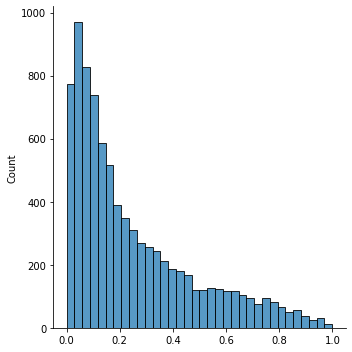

In [16]:
import seaborn as sns
sns.displot(y_pred_proba);

False    7138
True     1293
dtype: int64

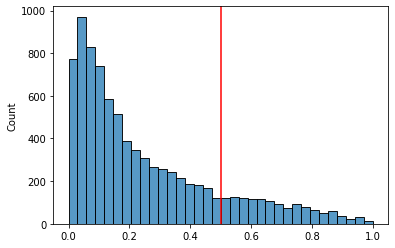

In [17]:
# Randomforestclassifier 기본 임계값은 0.5입니다.
threshold = 0.5
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.histplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [18]:
from ipywidgets import interact, fixed

def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [19]:
#(객관식) 임계값을 증가시킬때 positive 범주에 대한 재현율의 변화
print('임계값이 증가될 때 positive 범주에 대한 재현율은 낮아진다')

임계값이 증가될 때 positive 범주에 대한 재현율은 낮아진다


### 3) 랜덤포레스트의 n_estimator를 1, 10, 100, 1000으로 바꾸어 가며 positive 범주의 predict_proba를 비교해 보세요
- 파라미터는 다음과 같이 설정합니다.
    - n_jobs=-1, random_state=10, max_depth=None, n_estimators = n
- **(객관식) 확률값들의 분포(종류)의 변화를 과제 제출폼에 제출하세요**
    1. 다양해진다
    2. 변화가없다


In [20]:
pip install -U scikit-learn

검증 정확도:  0.734551061558534


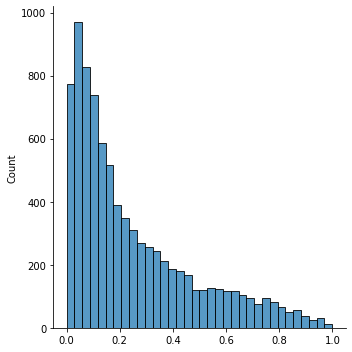

In [23]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1, random_state=10, n_jobs=-1, max_depth=None)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

sns.displot(y_pred_proba);

검증 정확도:  0.8082078045308979


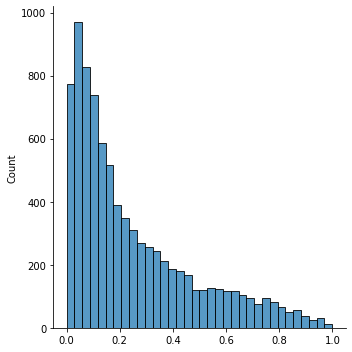

In [24]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=10, random_state=10, n_jobs=-1, max_depth=None)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

sns.displot(y_pred_proba);

검증 정확도:  0.8206618431977227


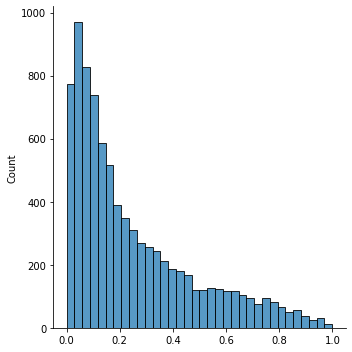

In [25]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1, max_depth=None)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

sns.displot(y_pred_proba);

검증 정확도:  0.8244573597438026


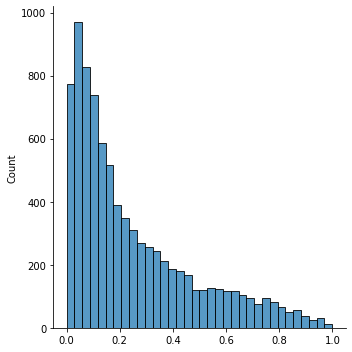

In [55]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, random_state=10, n_jobs=-1, max_depth=None)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

sns.displot(y_pred_proba);

In [56]:
#캐글 df 만들기
y_pred_f = pipe.predict(X_test)
sample_submission['y_pred_f']=y_pred_f

In [57]:
submission_2=sample_submission

In [58]:
submission_2.to_csv('submission_2.csv', index=False)

In [28]:
#(객관식) 확률값들의 분포(종류)의 변화
print('랜덤포레스트의 n_estimator를 바꾸더라도 확률값들의 분포 변화는 변함 없다')

랜덤포레스트의 n_estimator를 바꾸더라도 확률값들의 분포 변화는 변함 없다


### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.
- 더 좋은 결과가 나오는 모델을 사용해서 캐글에 제출하세요
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**

In [29]:
from sklearn.metrics import roc_curve

##첫번째 분류 모델은 위에서 진행한 랜덤포레스트
# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,2.000000
1,0.000000,0.000993,1.000000
2,0.000156,0.001985,0.990000
3,0.000312,0.001985,0.985000
4,0.000312,0.002978,0.980000
...,...,...,...
604,0.971945,0.996030,0.010000
605,0.972257,0.996030,0.007000
606,0.972724,0.997022,0.005000
607,0.973192,0.997022,0.001667


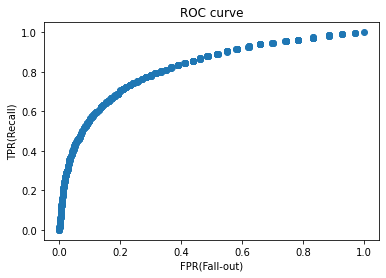

In [30]:
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [31]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 371 , threshold: 0.2910833333333333


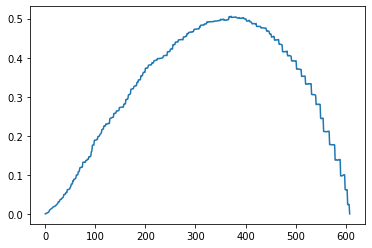

In [32]:
plt.plot(tpr-fpr);

In [49]:
y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      6416
           1       0.53      0.71      0.60      2015

    accuracy                           0.78      8431
   macro avg       0.71      0.75      0.72      8431
weighted avg       0.81      0.78      0.79      8431



In [34]:
#threshold 0.5 와 비교
y_pred_05 = y_pred_proba >= 0.5
print(classification_report(y_val, y_pred_05))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      6416
           1       0.70      0.46      0.55      2015

    accuracy                           0.82      8431
   macro avg       0.77      0.70      0.72      8431
weighted avg       0.81      0.82      0.81      8431



In [35]:
#AUC점수를 계산해 보겠습니다. AUC값은 높을 수록 좋음
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
auc_score

0.8199403399070561

In [48]:
## 두번째 모델 _ 의사결정트리

from sklearn.tree import DecisionTreeClassifier
from category_encoders import OneHotEncoder

pipe2 = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf=10, random_state=2)
)

pipe2.fit(X_train, y_train)

print('훈련 정확도', pipe2.score(X_train, y_train))
print('검증 정확도', pipe2.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도 0.8577825223141476
검증 정확도 0.8029889692800379


## 🔥 도전과제

### 5) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 